In [1]:

import os
os.chdir("/mnt/home/amir/framingdecomp/framingDecomp")

import sys
sys.path.append(os.getcwd())

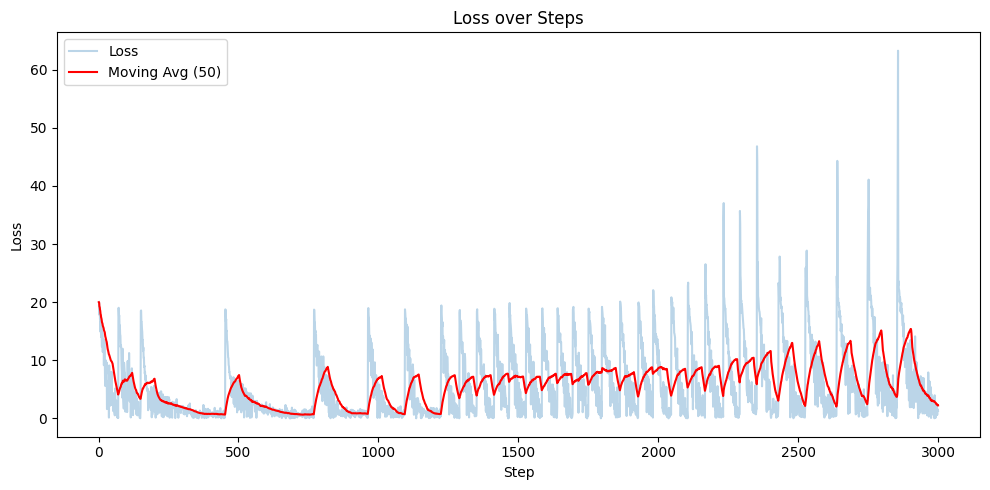

In [2]:
import re
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Usage: python plot_loss.py path/to/logfile.log

logfile = './logs/decomposer_20250722_025458_074a110c-2578-4143-87f1-763b1c892868.log'

losses = []

# Regex to extract loss value (edit if your log format is different)
loss_pattern = re.compile(r'loss[:=]\s*([0-9.]+)')

with open(logfile, 'r') as f:
    for line in f:
        match = loss_pattern.search(line)
        if match:
            losses.append(float(match.group(1)))

if not losses:
    print("No loss values found. Adjust the regex if needed.")
    sys.exit(1)

steps = list(range(1, len(losses) + 1))
df = pd.DataFrame({'step': steps, 'loss': losses})
df['loss_ma'] = df['loss'].rolling(window=50, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(df['step'], df['loss'], label='Loss', alpha=0.3)
plt.plot(df['step'], df['loss_ma'], label='Moving Avg (50)', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.legend()
plt.tight_layout()
plt.show()

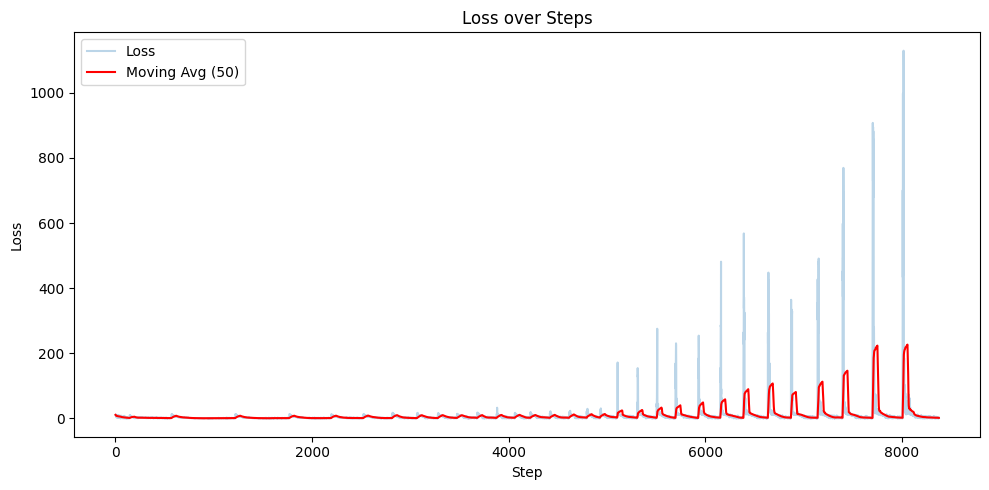

In [3]:
import re
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Usage: python plot_loss.py path/to/logfile.log

logfile = './logs/decomposer_20250722_025458_074a110c-2578-4143-87f1-763b1c892868.log' #llama 3
logfile = './logs/decomposer_20250718_235345.log' #llama 2

losses = []

# Regex to extract loss value (edit if your log format is different)
loss_pattern = re.compile(r'loss[:=]\s*([0-9.]+)')

with open(logfile, 'r') as f:
    for line in f:
        match = loss_pattern.search(line)
        if match:
            losses.append(float(match.group(1)))

if not losses:
    print("No loss values found. Adjust the regex if needed.")
    sys.exit(1)

steps = list(range(1, len(losses) + 1))
df = pd.DataFrame({'step': steps, 'loss': losses})
df['loss_ma'] = df['loss'].rolling(window=50, min_periods=1).mean()

plt.figure(figsize=(10, 5))
plt.plot(df['step'], df['loss'], label='Loss', alpha=0.3)
plt.plot(df['step'], df['loss_ma'], label='Moving Avg (50)', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Steps')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
#!/usr/bin/env python3
"""
Script to parse training log files and plot loss values by layer.
Creates subplots for each layer showing loss progression with moving average smoothing.
"""

import re
import sys
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

def parse_log_file(logfile_path):
    """
    Parse the log file and extract loss values for each layer.
    
    Args:
        logfile_path (str): Path to the log file
        
    Returns:
        dict: Dictionary with layer numbers as keys and lists of (step, loss) tuples as values
    """
    layer_data = defaultdict(list)
    
    # Regex to match lines like: "layer 0, [0:49], loss=19.9910"
    pattern = re.compile(r'layer (\d+), \[(\d+):(\d+)\], loss=([0-9.-]+)')
    
    with open(logfile_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                layer = int(match.group(1))
                step_start = int(match.group(2))
                step_end = int(match.group(3))
                loss = float(match.group(4))
                
                # Use the end step as the step number
                layer_data[layer].append((step_end, loss))
    
    return layer_data


def plot_loss_by_layer(layer_data, window_size=50, figsize=(20, 30)):
    plt.close('all')
    layers = sorted(layer_data.keys())
    num_layers = len(layers)
    num_cols = 2
    num_rows = (num_layers + 1) // 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    fig.suptitle('Training Loss by Layer', fontsize=16, y=0.98)

    if num_rows == 1:
        axes = axes.reshape(1, -1)

    for i, layer in enumerate(layers):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.clear()

        # Sort by step to ensure monotonic x-axis
        data = sorted(layer_data[layer], key=lambda x: x[0])
        steps, losses = zip(*data)

        df = pd.DataFrame({'step': steps, 'loss': losses})
        df['loss_ma'] = df['loss'].rolling(window=window_size, min_periods=1).mean()

        # ax.plot(df['step'], df['loss'], alpha=0.3, color='blue', linewidth=0.5, label='Raw Loss')
        ax.plot(df['step'], df['loss_ma'], color='red', linewidth=1.5, label=f'MA ({window_size})')

        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.set_title(f'Layer {layer}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        if len(losses) > 0:
            # TODO: change to range by loss itself if needed
            loss_range = max(df['loss_ma']) - min(df['loss_ma'])
            if loss_range > 0:
                ax.set_ylim(min(df['loss_ma']) - 0.1 * loss_range, max(df['loss_ma']) + 0.1 * loss_range)
            ax.set_xlim(window_size*2, max(df['step'])*1.05)

    for i in range(num_layers, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    return fig

def main(logfile_path, model_name=''):
    if len(sys.argv) != 2:
        print("Usage: python plot_loss_by_layer.py <log_file_path>")
        sys.exit(1)
    
    
    try:
        # Parse the log file
        print(f"Parsing log file: {logfile_path}")
        layer_data = parse_log_file(logfile_path)
        
        if not layer_data:
            print("No loss data found in the log file.")
            sys.exit(1)
        
        print(f"Found data for {len(layer_data)} layers: {sorted(layer_data.keys())}")
        
        # Create the plot
        print("Creating plot...")
        fig = plot_loss_by_layer(layer_data)
        
        # Save the plot
        output_file = logfile_path.replace('.log', f'{model_name}_loss_plot.png')
        fig.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Plot saved as: {output_file}")
        
        # Show the plot
        plt.show()
        
    except FileNotFoundError:
        print(f"Error: Log file '{logfile_path}' not found.")
        sys.exit(1)
    except Exception as e:
        print(f"Error: {e}")
        sys.exit(1)


Processing model: vicuna-7b with log file: ./logs/decomposer_20250721_204858.log
Parsing log file: ./logs/decomposer_20250721_204858.log
Found data for 32 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Creating plot...


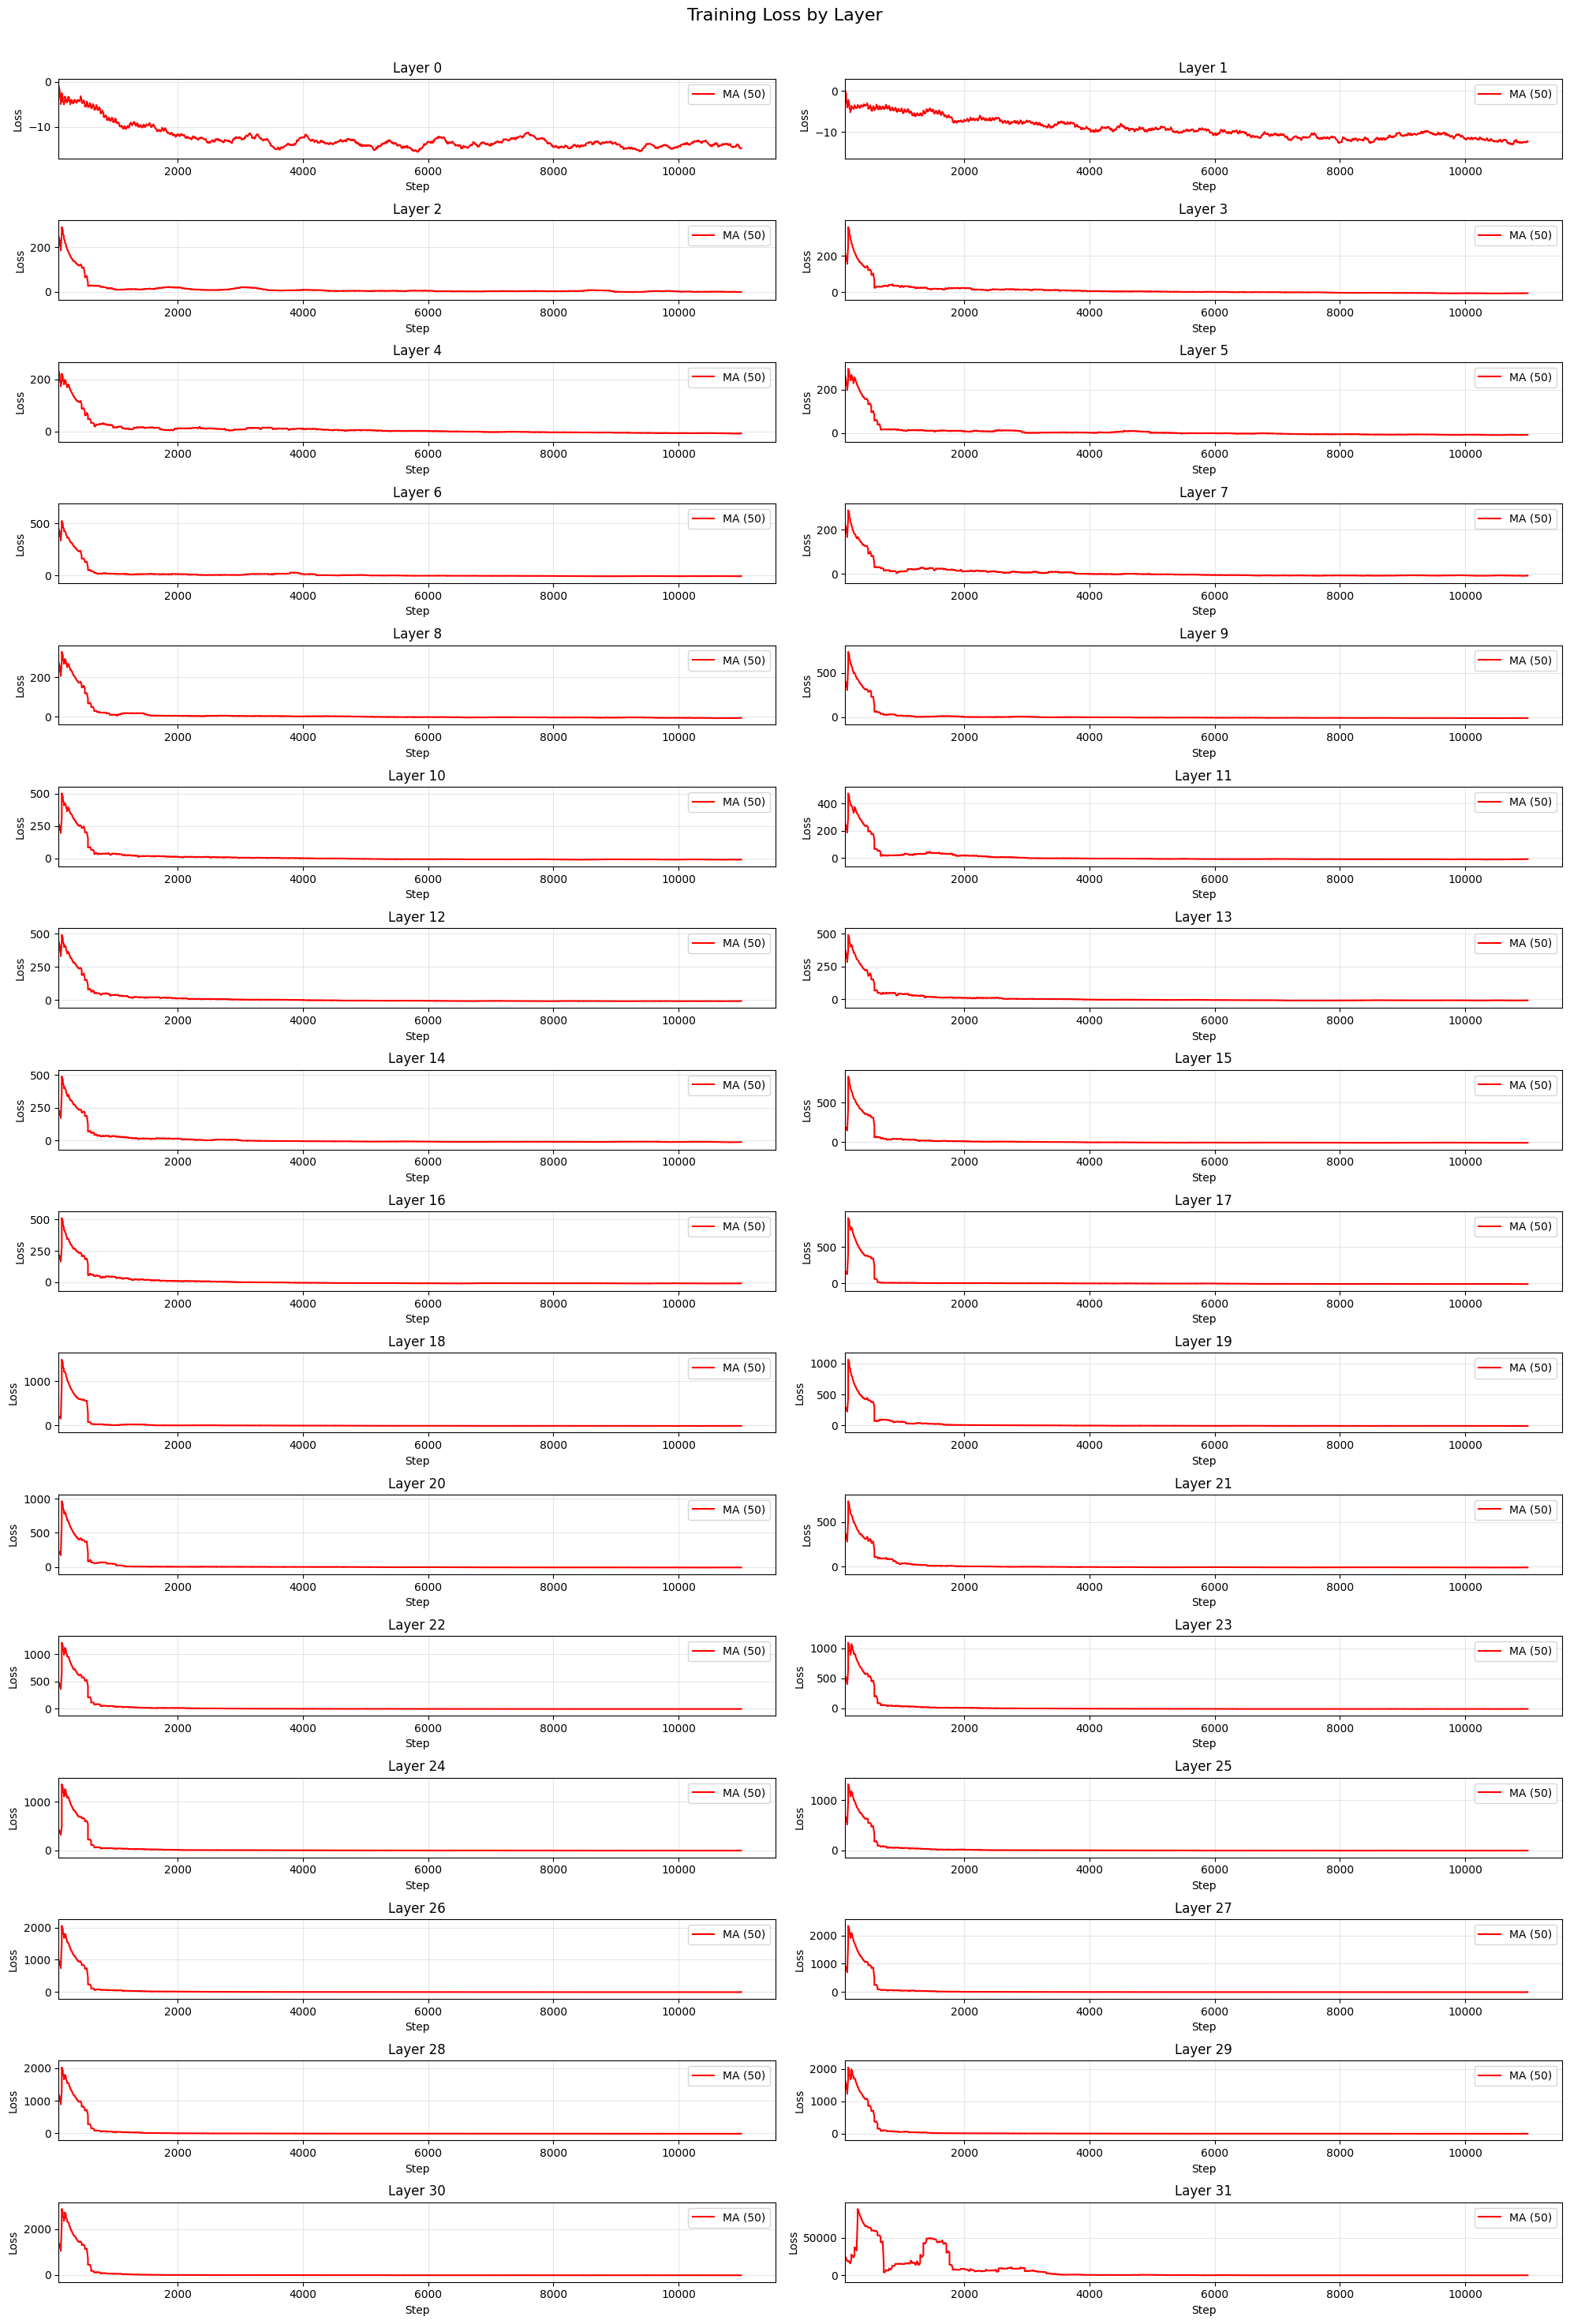

Plot saved as: ./logs/decomposer_20250721_204858vicuna-7b_loss_plot.png
Processing model: vicuna-13b with log file: ./logs/decomposer_20250722_171500_d895e0d2-babf-4915-b4f4-79de5c156b86.log
Parsing log file: ./logs/decomposer_20250722_171500_d895e0d2-babf-4915-b4f4-79de5c156b86.log
Found data for 40 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Creating plot...


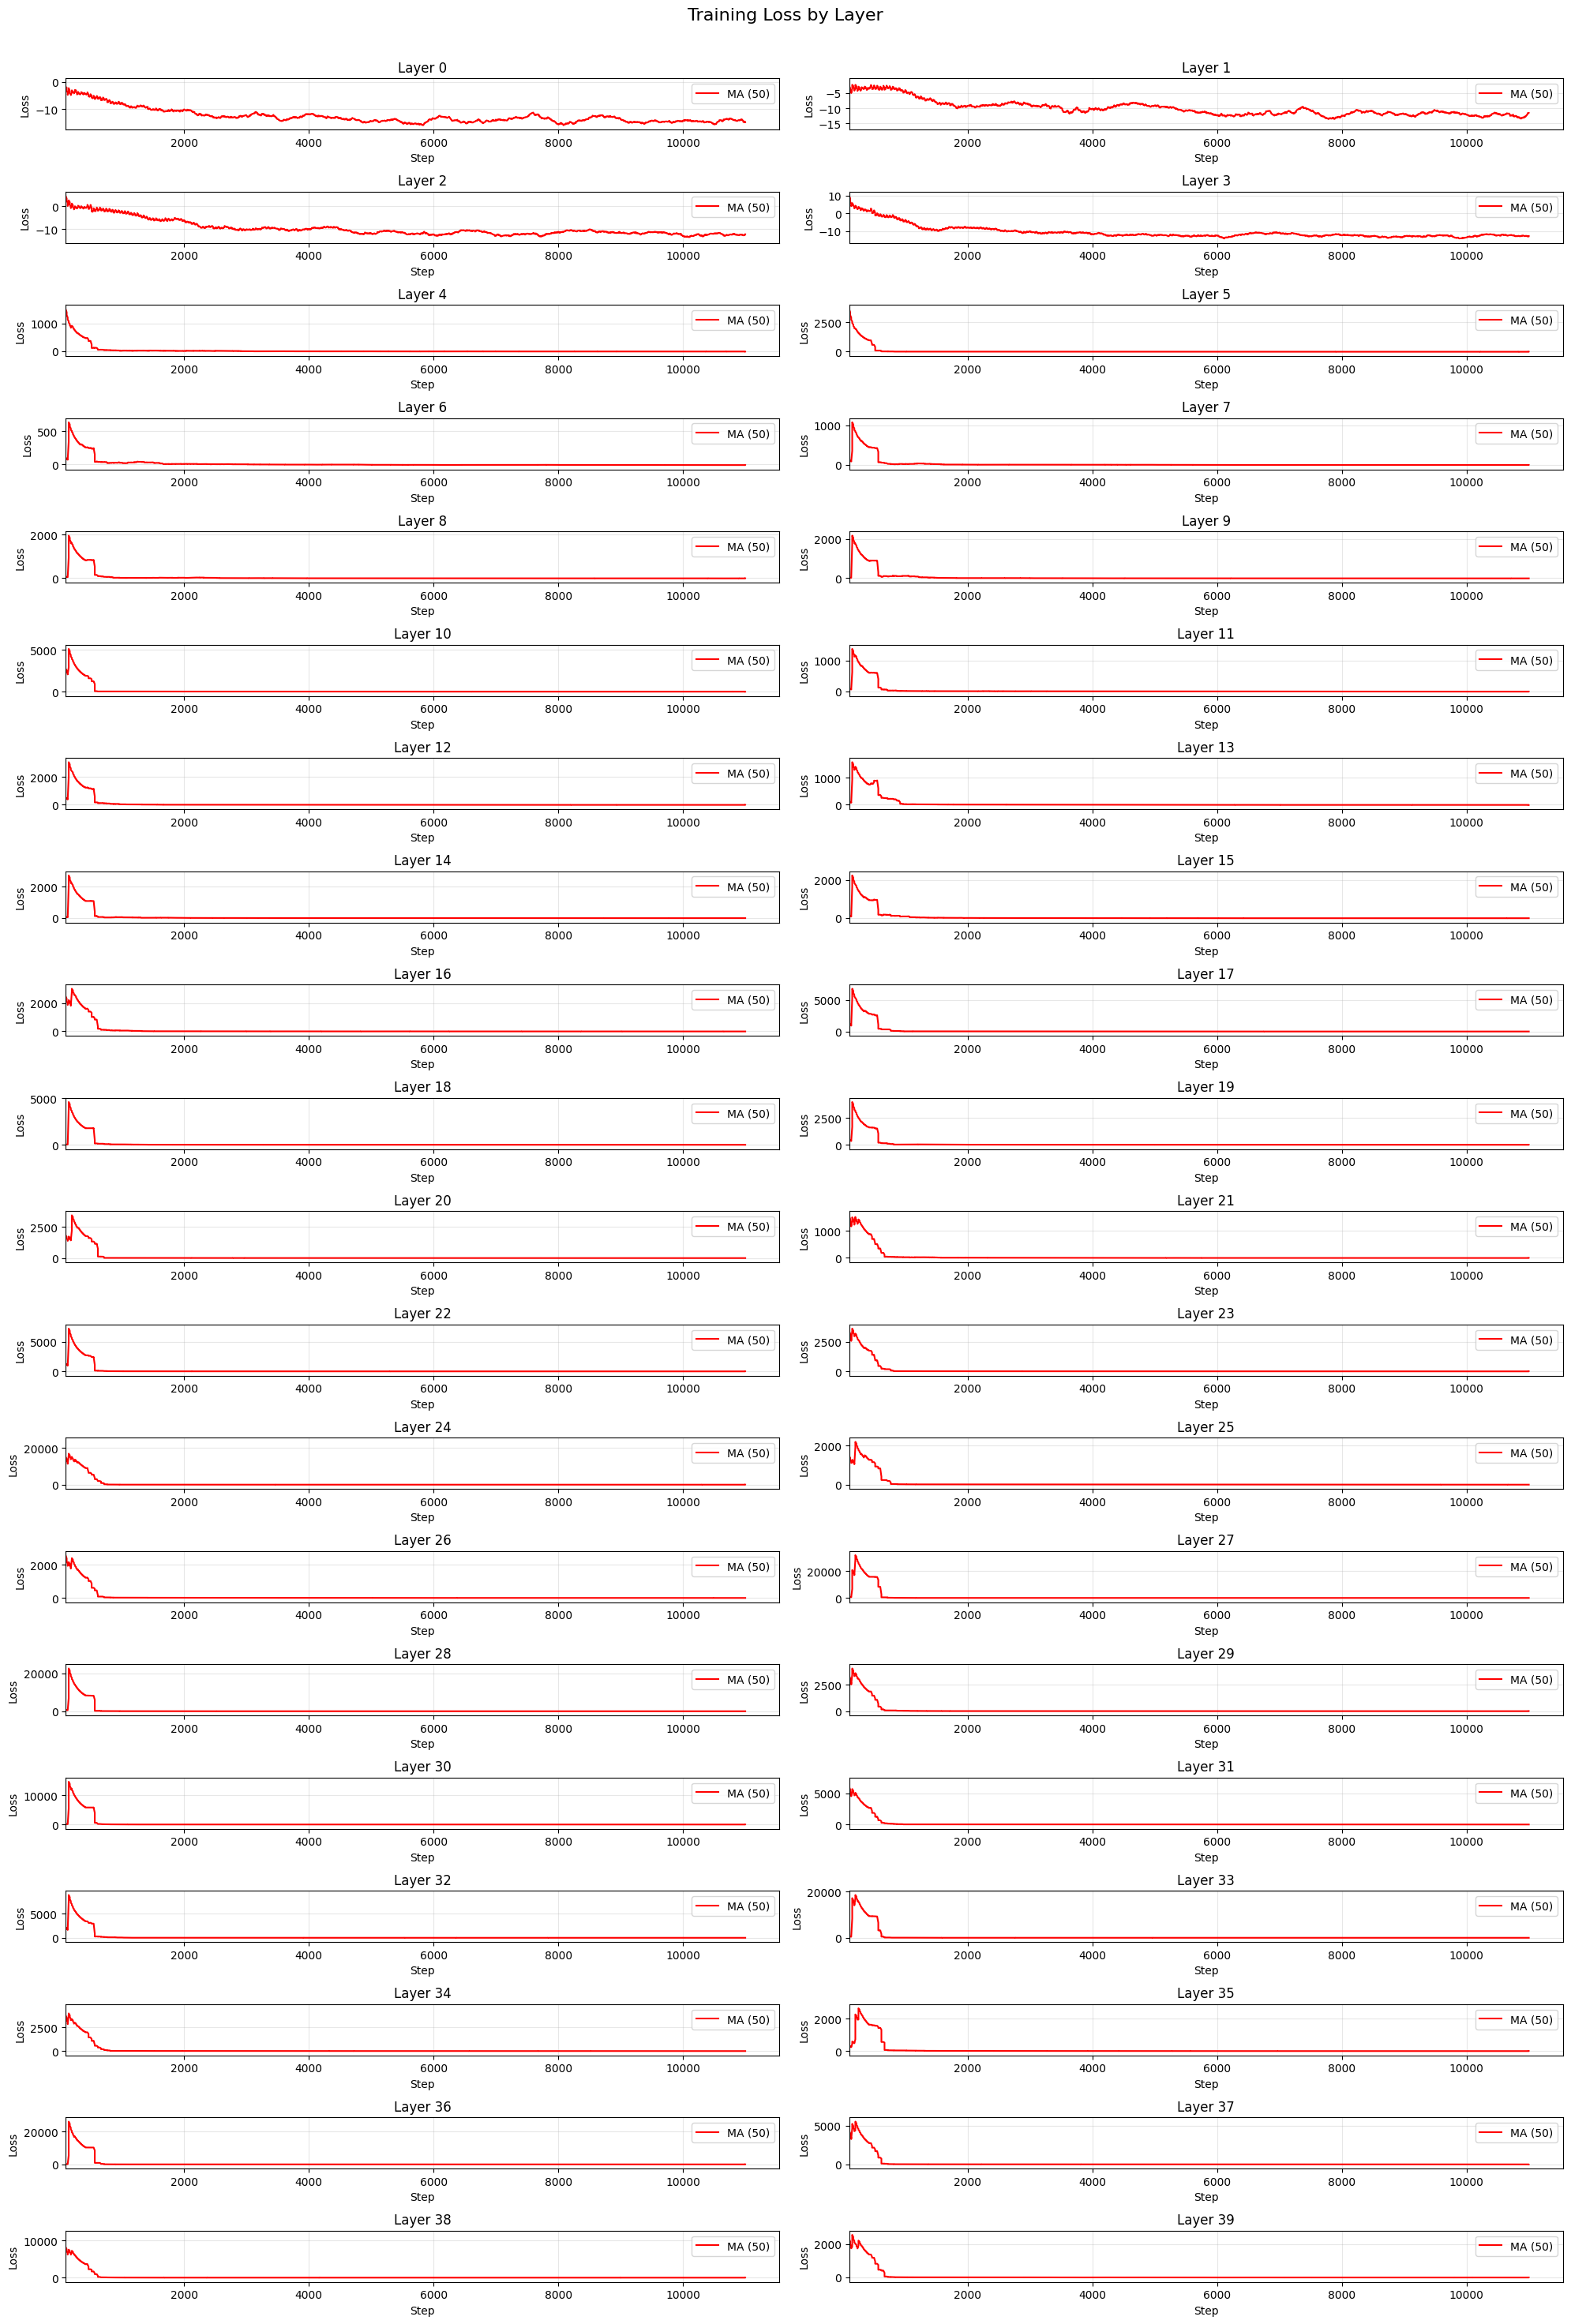

Plot saved as: ./logs/decomposer_20250722_171500_d895e0d2-babf-4915-b4f4-79de5c156b86vicuna-13b_loss_plot.png
Processing model: llama-2-7b with log file: ./logs/decomposer_20250718_235345.log
Parsing log file: ./logs/decomposer_20250718_235345.log
Found data for 32 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Creating plot...


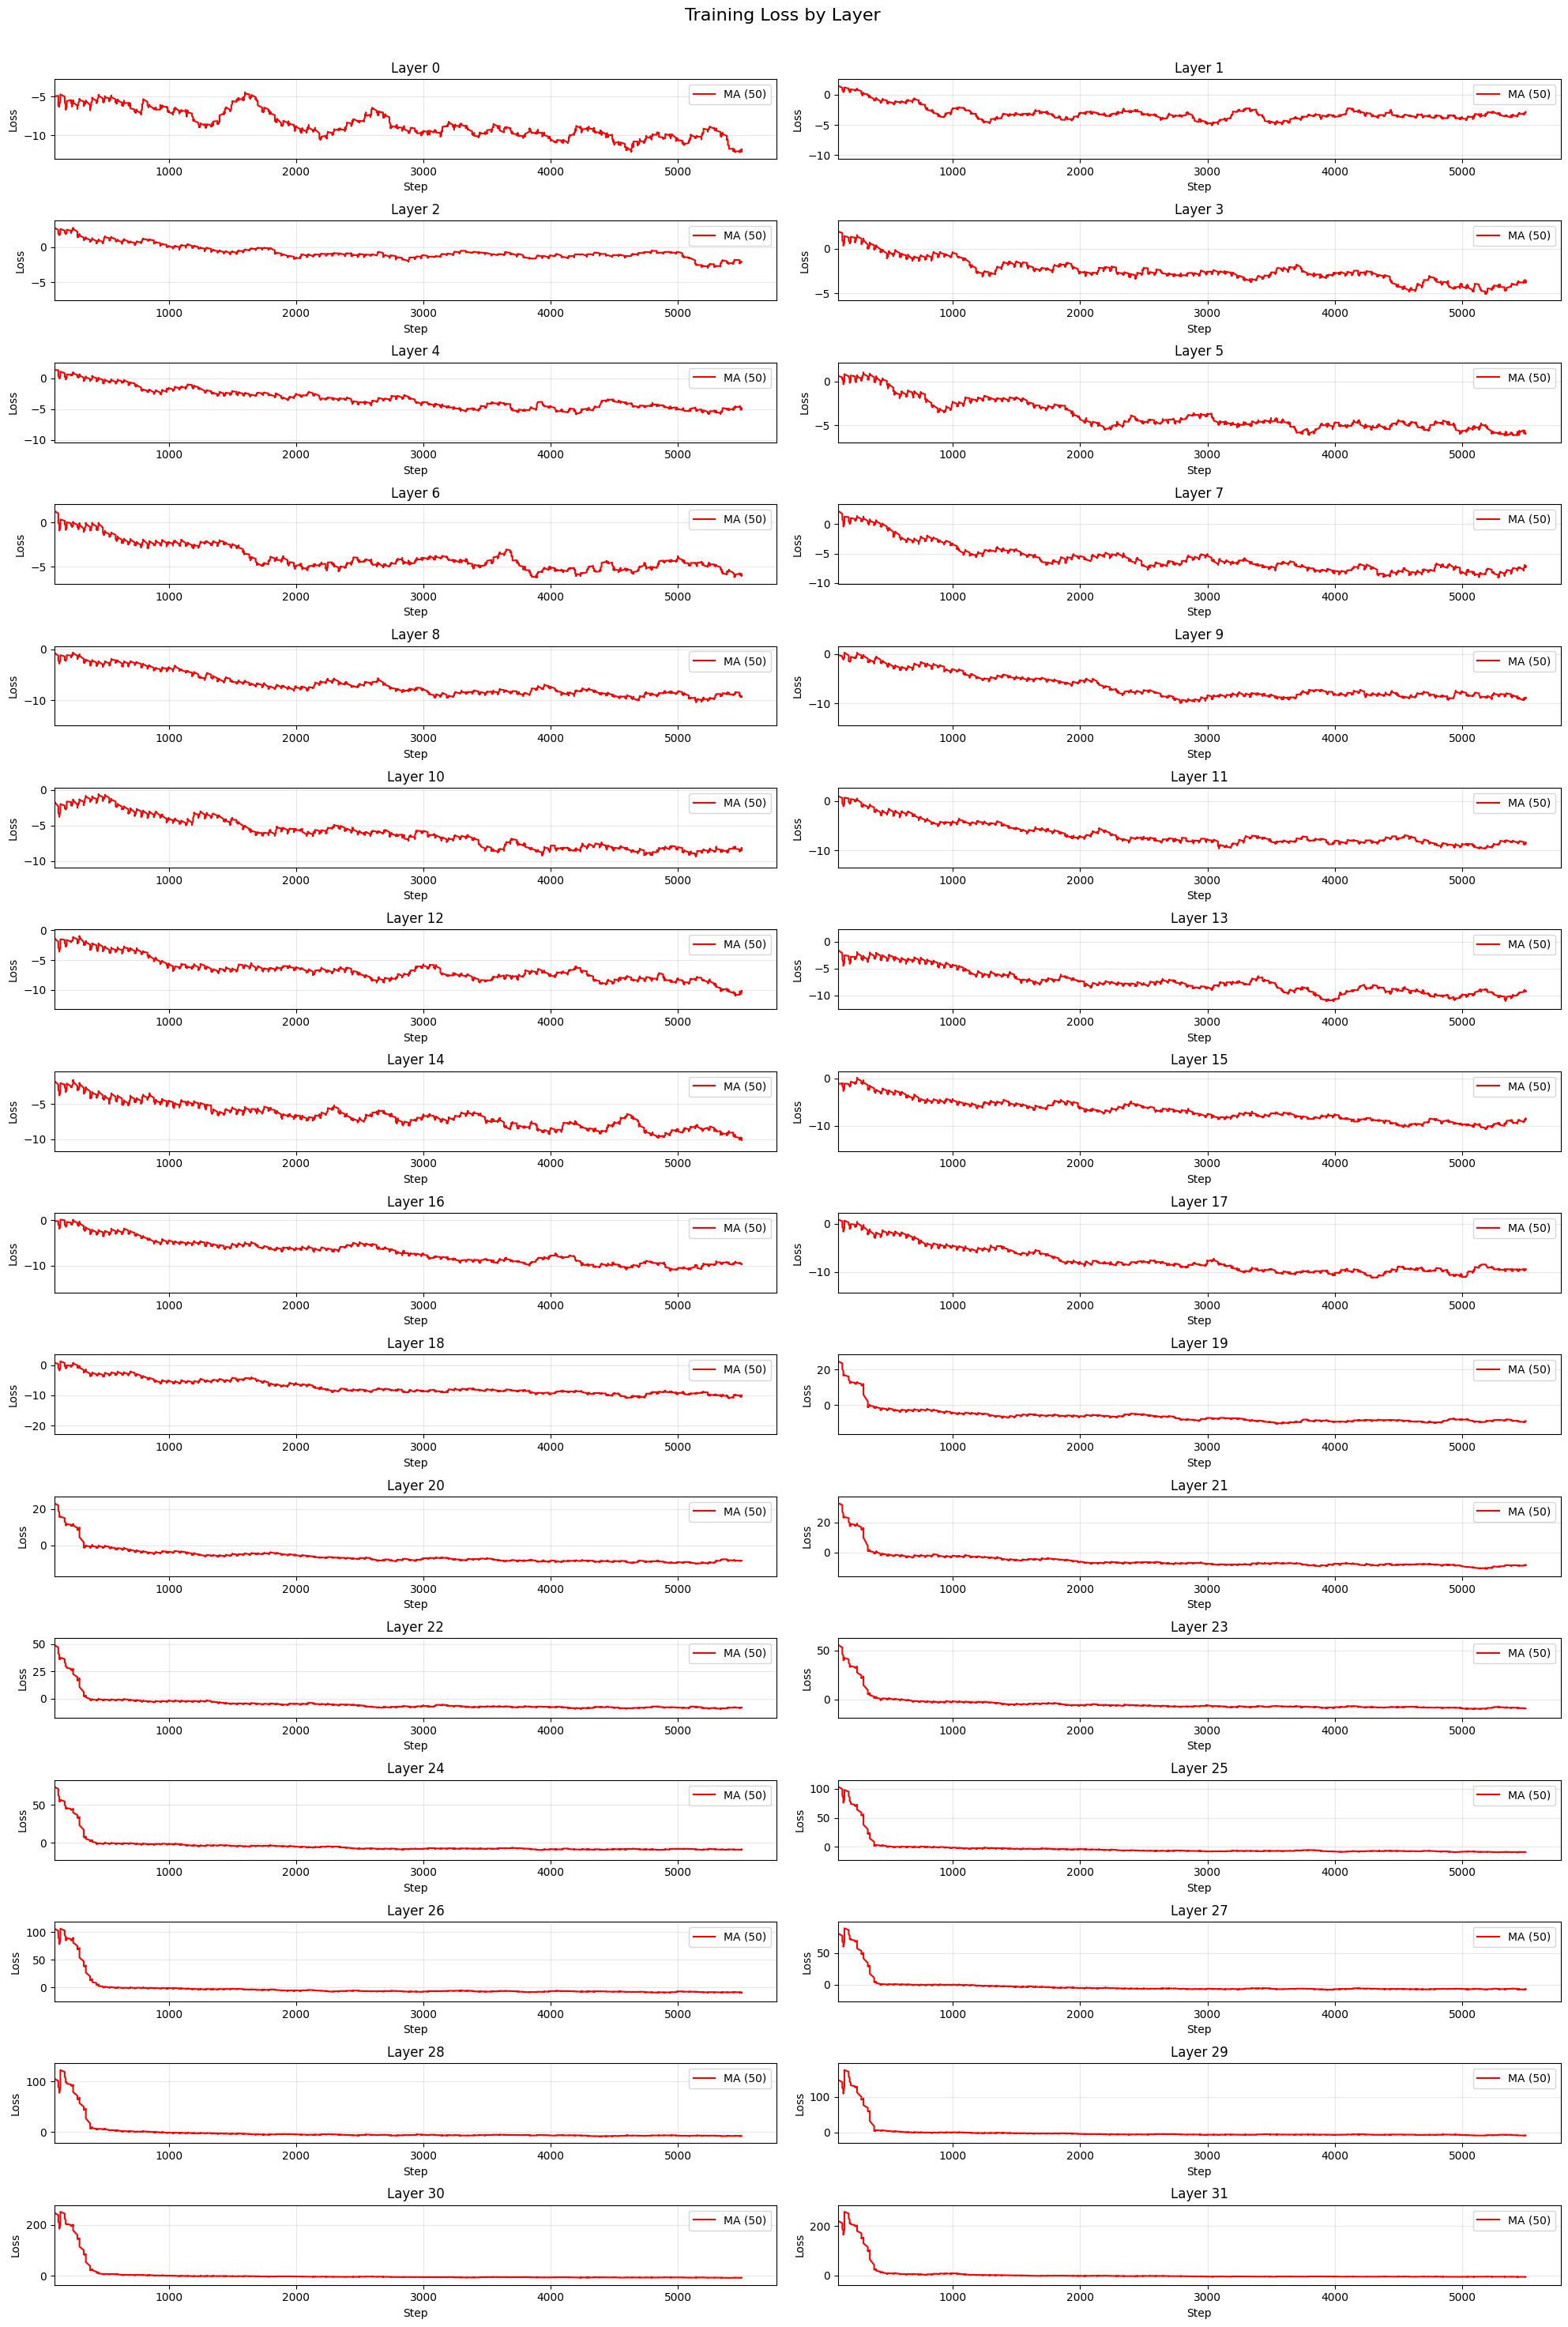

Plot saved as: ./logs/decomposer_20250718_235345llama-2-7b_loss_plot.png
Processing model: llama-3-8b with log file: ./logs/decomposer_20250722_025458_074a110c-2578-4143-87f1-763b1c892868.log
Parsing log file: ./logs/decomposer_20250722_025458_074a110c-2578-4143-87f1-763b1c892868.log
Found data for 32 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Creating plot...


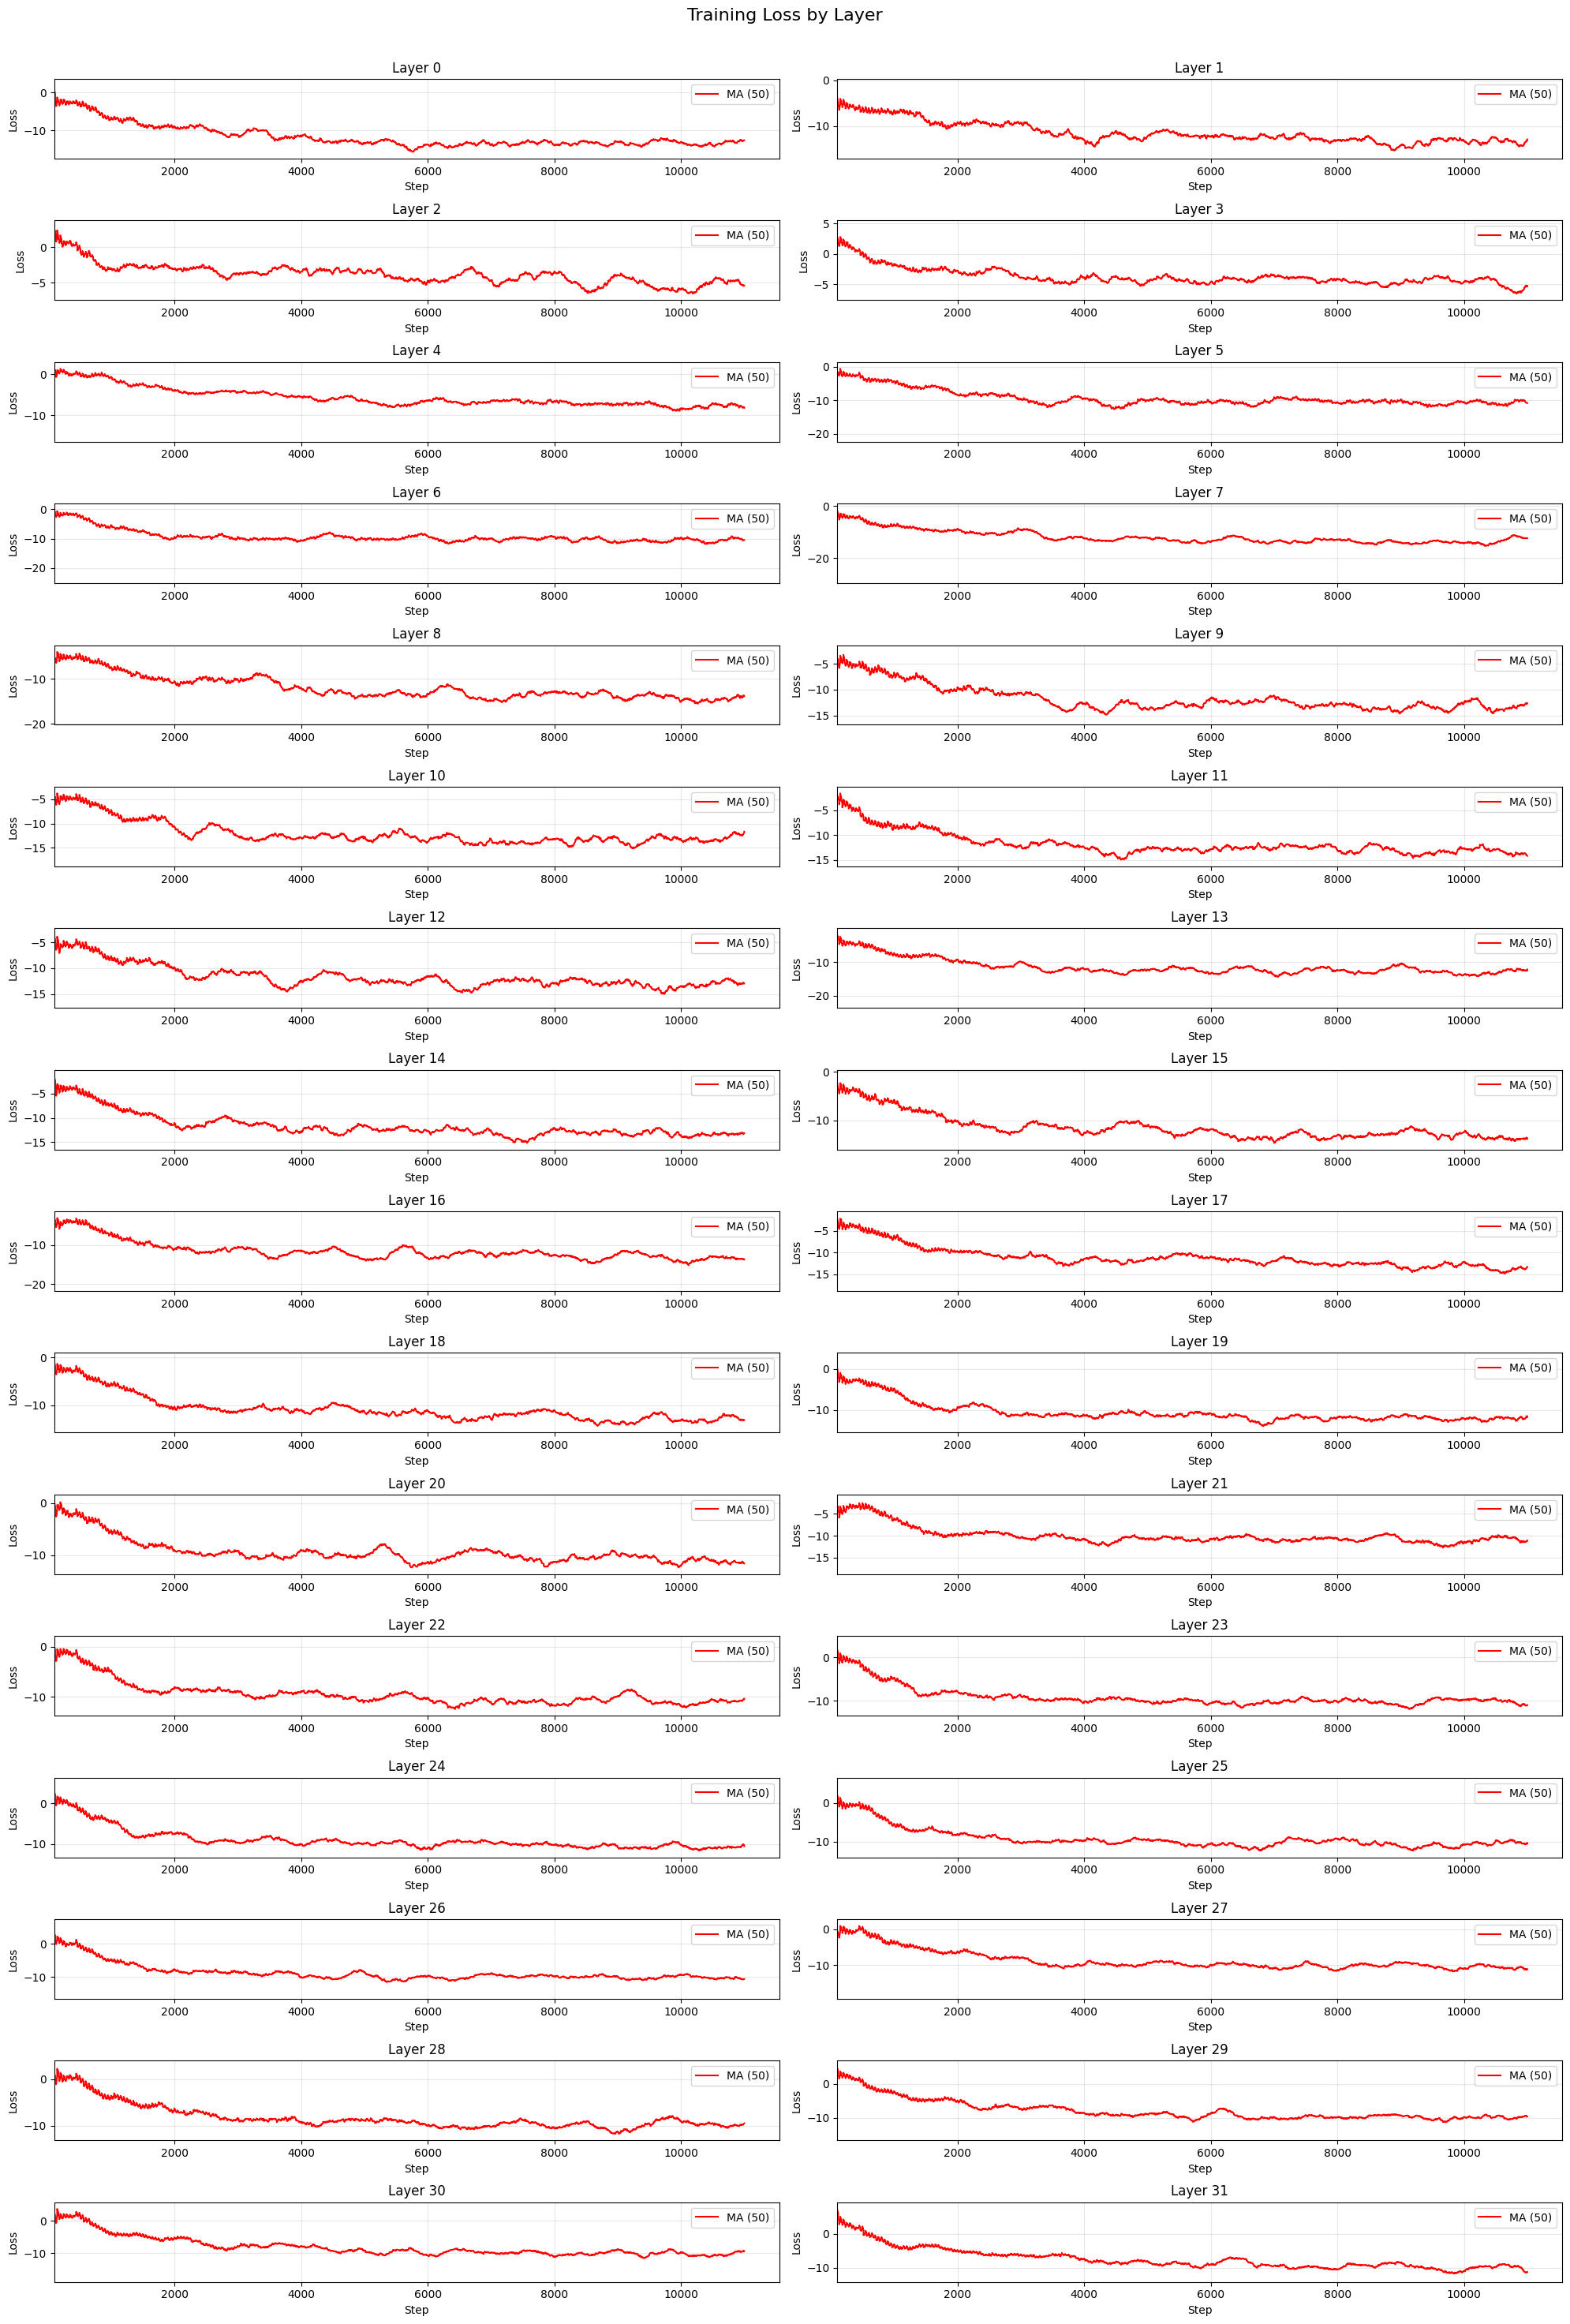

Plot saved as: ./logs/decomposer_20250722_025458_074a110c-2578-4143-87f1-763b1c892868llama-3-8b_loss_plot.png
Processing model: mistral-7b with log file: ./logs/decomposer_20250722_164739_1a86b97e-6703-4060-8cc0-21ed0a7bc089.log
Parsing log file: ./logs/decomposer_20250722_164739_1a86b97e-6703-4060-8cc0-21ed0a7bc089.log
Found data for 32 layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Creating plot...


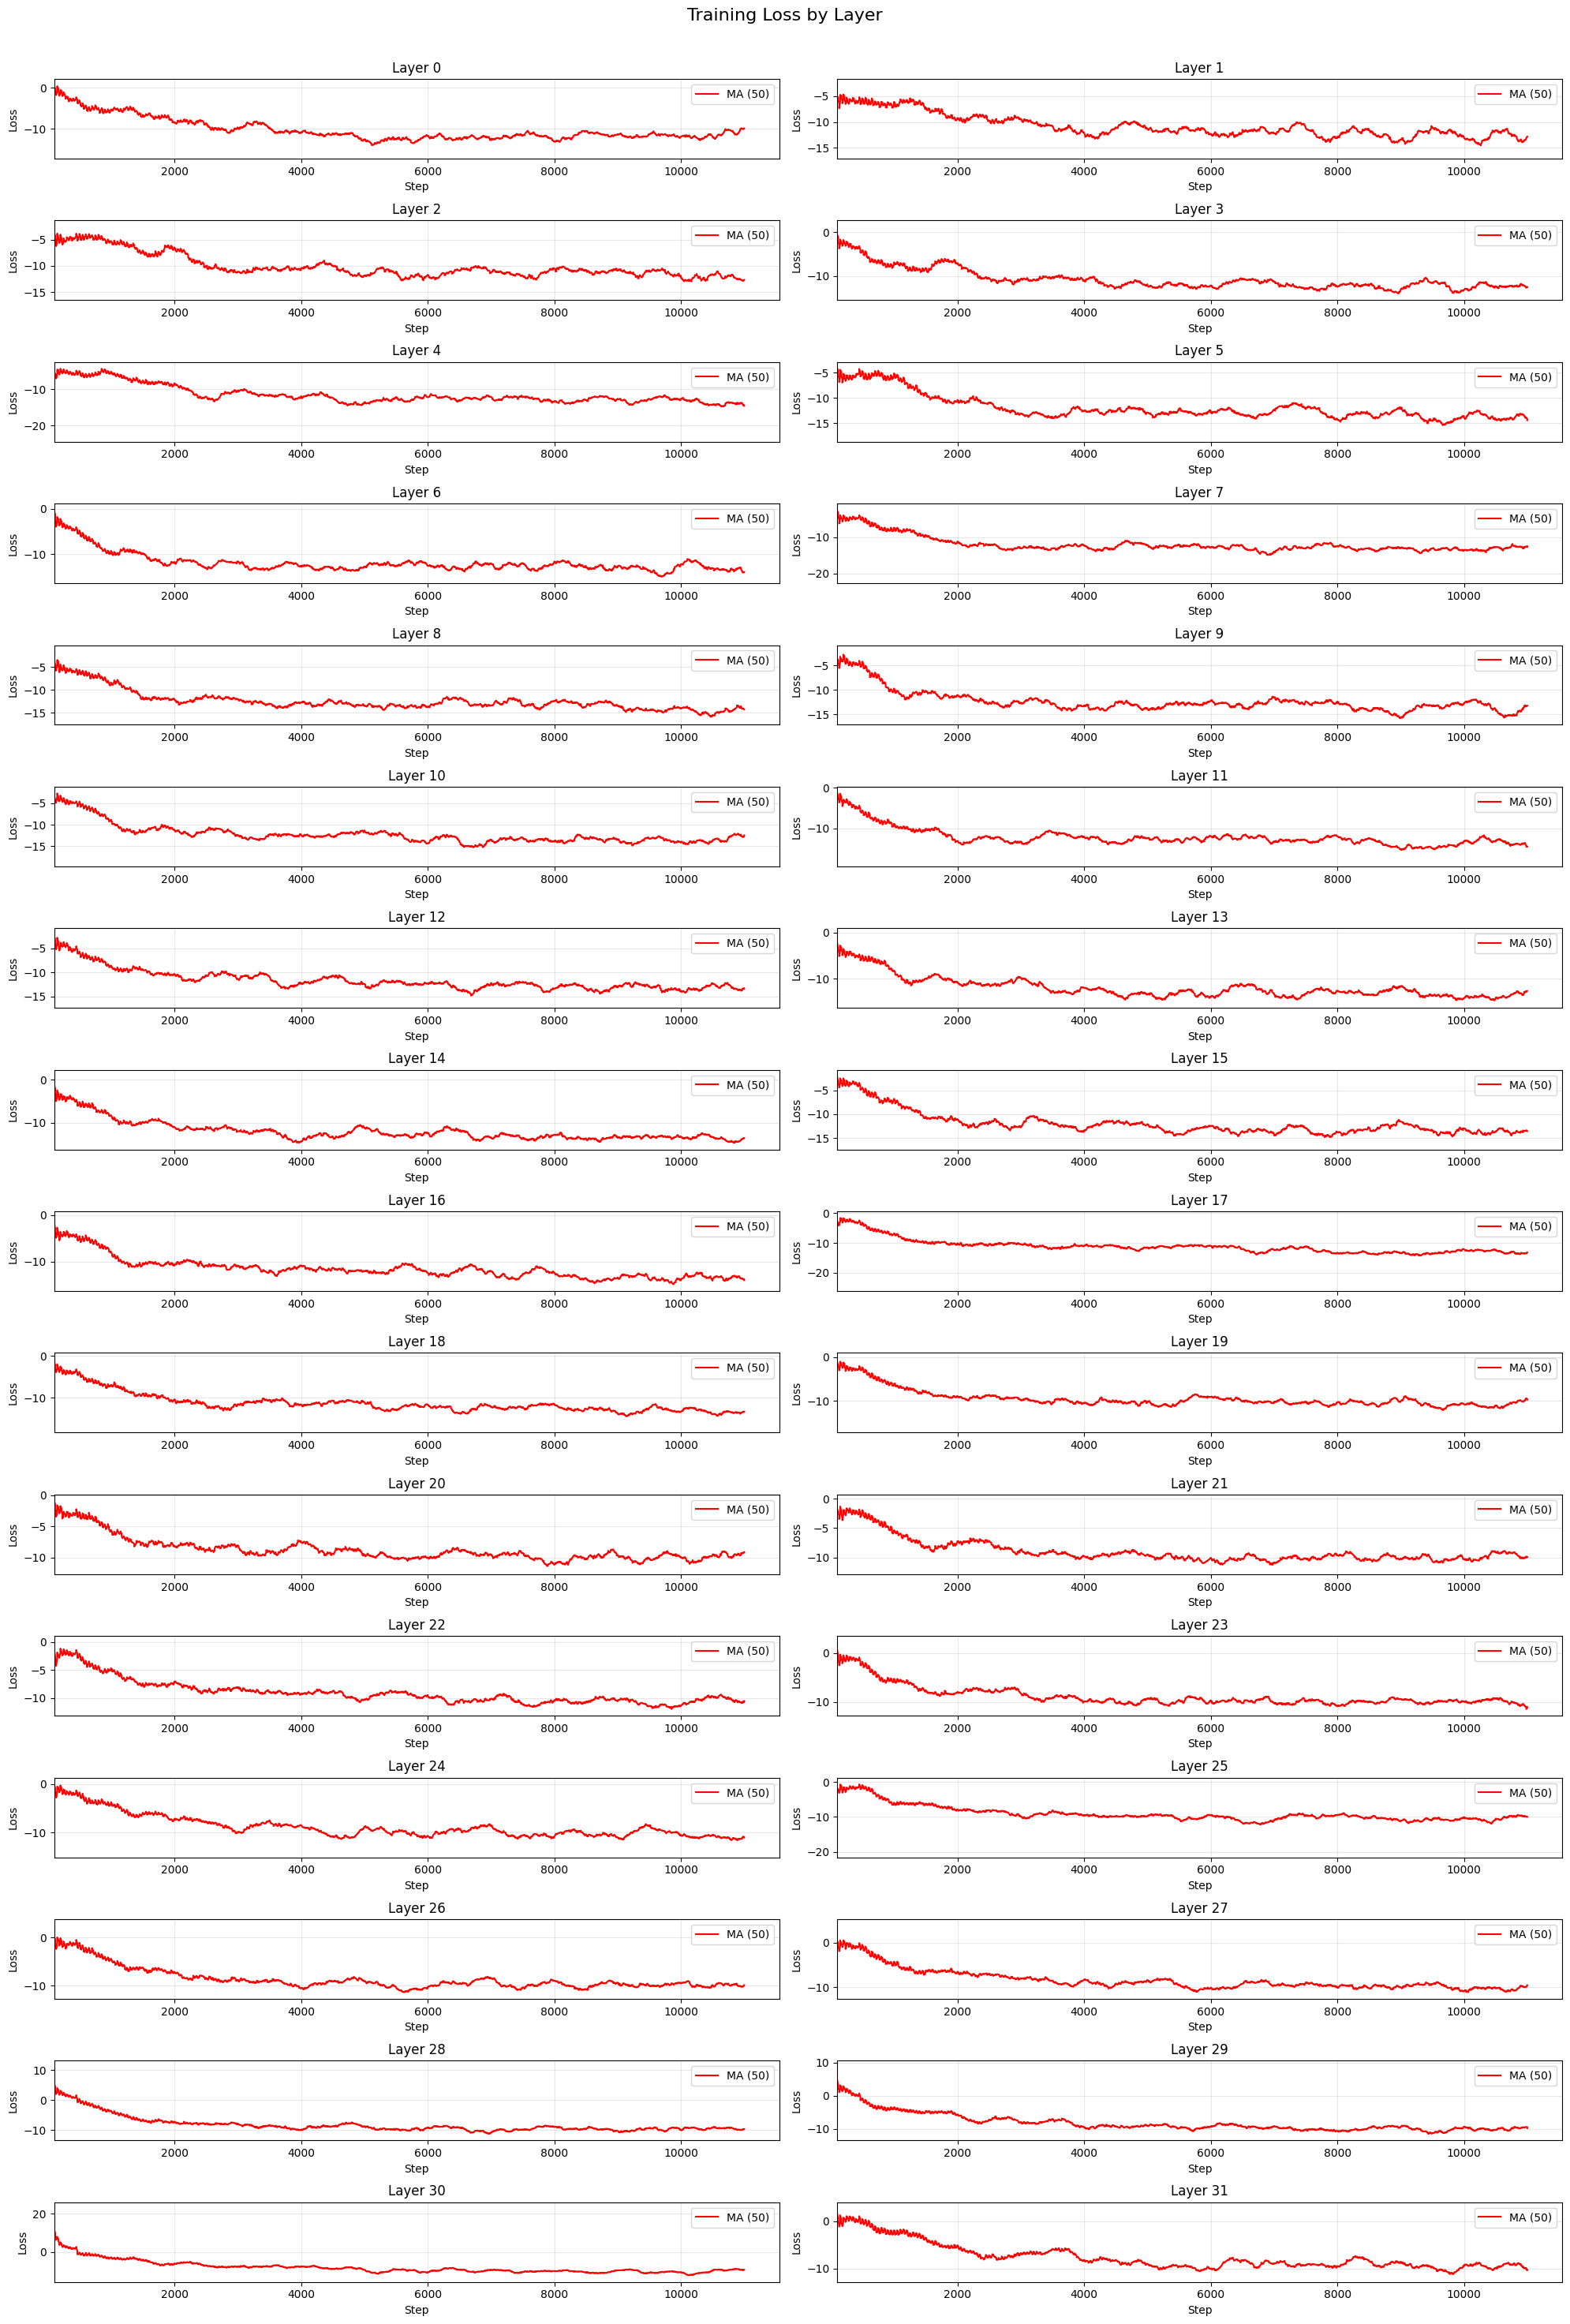

Plot saved as: ./logs/decomposer_20250722_164739_1a86b97e-6703-4060-8cc0-21ed0a7bc089mistral-7b_loss_plot.png


In [26]:

log_model = [('vicuna-7b','./logs/decomposer_20250721_204858.log'), 
             ('vicuna-13b','./logs/decomposer_20250722_171500_d895e0d2-babf-4915-b4f4-79de5c156b86.log'), 
             ('llama-2-7b','./logs/decomposer_20250718_235345.log'), 
             ('llama-3-8b','./logs/decomposer_20250722_025458_074a110c-2578-4143-87f1-763b1c892868.log'), 
             ('mistral-7b','./logs/decomposer_20250722_164739_1a86b97e-6703-4060-8cc0-21ed0a7bc089.log')]
for model_name, logfile in log_model:
    print(f"Processing model: {model_name} with log file: {logfile}")
    main(logfile, model_name=model_name)